## Analysis of holtankoljak.hu station and gas price data

In [1]:
import pandas as pd
import numpy as np

from ast import literal_eval
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import stylecloud
from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/scraped_data.csv')
data.head(3)

,link,address,geo_location,services,open_hours,prices
0,https://holtankoljak.hu/omv_cece_vasutu2,"Cece, Vasút u. 2.","46.77132797,18.62500381","['kávé', ' bankkártya elfogadás', ' WC', ' ker...","['Hétfő:06:00 - 20:00', 'Kedd:06:00 - 20:00', ...","{'Gázolaj': 'Nem ismert', 'Prémium Gázolaj': '..."
1,https://holtankoljak.hu/mol_pecs_versenyutca1,"Pécs, Verseny utca 1.","46.06662369,18.23132706","['autópálya-matrica', ' mobiltelefon egyenlegf...","['Hétfő:06:00 - 22:00', 'Kedd:06:00 - 22:00', ...","{'Lpg': '325.9,- Ft', 'Cng': '435.0,- Ft /kg20..."
2,https://holtankoljak.hu/mol_kecskemet_kiskunfe...,"Kecskemét, Kiskunfélegyházi út (Szegedi út)","46.88214874,19.70771980","['HU-GO feltöltés', ' kenőolaj', ' UTA-kártya'...","['Hétfő:06:00 - 22:00', 'Kedd:06:00 - 22:00', ...","{'95-ös Benzin E10': '479.9,- Ft', 'Prémium Gá..."


### Clean up features

In [3]:
### GEO COORDS

data[['LAT', 'LON']] = data['geo_location'].str.split(',', expand = True).astype(float)
data.drop('geo_location', 1, inplace = True)

In [4]:
### PRICES

gas_types = pd.json_normalize(data['prices'].apply(eval))
gas_types.replace({'Nem ismert' : np.nan}, inplace = True)

NaN_count = gas_types.isnull().sum() / gas_types.shape[0]
keep_cols = NaN_count[NaN_count <= .75]
print('Keeping the following gas types:', keep_cols.index.tolist())

gas_types = gas_types[keep_cols.index.tolist()]

for i in gas_types.columns:
    gas_types[i] = gas_types[i].str.replace(',- Ft', '').astype(float)

data = pd.concat([data, gas_types], 1).drop(['prices'], 1)

Keeping the following gas types: ['Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5']


In [5]:
### OPEN HOURS

hours = data['open_hours'].apply(eval).apply(pd.Series)
hours.columns = ['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']

for i in hours.columns:

    hours[i] = hours[i]\
                    .str.replace('Hétfő:', '')\
                    .str.replace('Kedd:', '')\
                    .str.replace('Szerda:', '')\
                    .str.replace('Csütörtök:', '')\
                    .str.replace('Péntek:', '')\
                    .str.replace('Szombat:', '')\
                    .str.replace('Vasárnap:', '')\
                    .str.replace('0-24 óráig', '00:00 - 24:00')\
                    .str.replace('00:00 - 23:59', '00:00 - 24:00')\
                    .str.replace('00:00 - 00:00', '00:00 - 24:00')\
                    .str.replace('Zárva', '00:00 - 00:00')

def calc_hours_open(_time):
    
    OPEN = _time.split(' - ')[0]
    OPEN_CONV = int(OPEN.split(':')[0]) + int(OPEN.split(':')[1]) / 60

    CLOSE = _time.split(' - ')[1]
    CLOSE_CONV = int(CLOSE.split(':')[0]) + int(CLOSE.split(':')[1]) / 60

    HOURS_OPEN = CLOSE_CONV - OPEN_CONV

    return HOURS_OPEN

for i in hours.columns:
    hours[i] = hours[i].apply(lambda x: calc_hours_open(x))

data = pd.concat([data, hours], 1).drop(['open_hours'], 1)

In [74]:
### LINK

brands = pd.DataFrame(data['link'].str.replace('https://holtankoljak.hu/', '').str.split('_', expand = True)[0])

brand_mapper = {'mobil' : 'mobil-petrol', 'mol-partner' : 'mol'}
brands[0].replace(brand_mapper, inplace = True)

brand_keep = brands[0].value_counts().head(11).index.tolist()
brands.loc[~brands[0].isin(brand_keep), 0] = 'magan'
brands.columns = ['brand']

data = pd.concat([data, brands], 1)

In [77]:
### BUDAPEST or NOT

data['Budapest'] = 0
data.loc[data['link'].str.contains('budap'), 'Budapest'] = 1
data.drop('link', 1, inplace = True)

In [107]:
### AUTOPALYA or not

data['Highway'] = 0
data.loc[(data['address'].str.lower().str.contains('km')) | 
          (data['address'].str.lower().str.contains('autópálya')) | 
          (data['address'].str.lower().str.contains('m1|m2|m2|m4|m5|m6|m7')), 'Highway'] = 1
data.drop('address', 1, inplace = True)

In [128]:
### SERVICES

all_services = data['services'].apply(eval).apply(lambda x: [i.strip() for i in x if i != '']).tolist()

all_services_flat = [item for sublist in all_services for item in sublist]
all_services_set = list(set(all_services_flat))

print('Number of total unique services available:', len(all_services_set))

Number of total unique services available: 48


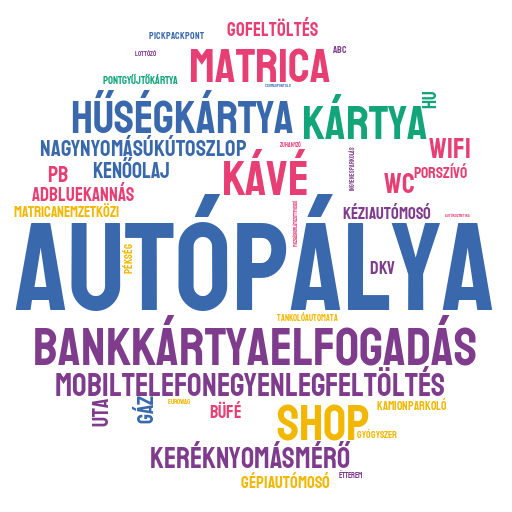

In [150]:
wc_data = ' '.join([i.replace(' ', '') for i in all_services_flat])

stylecloud.gen_stylecloud(wc_data, max_words = 750, max_font_size = 350, icon_name = 'fas fa-circle',
                          output_name = 'data/services.png', collocations = False)

display(Image(filename = 'data/services.png', width = 450))